# Working with surftemp-sst data


## Tutorial 2 - Worked Example - Marine Heatwaves

This tutorial provides a more in-depth example of working with the Sea Surface Temperature Daily Analysis dataset: European Space Agency Climate Change Initiative product version 2.1

A brief summary of this dataset is:

> Global daily-mean sea surface temperatures, presented on a 0.05° latitude-longitude grid, with gaps between available daily observations filled by statistical means, spanning late 1981 to recent time.
>
> Synthesised from multiple Earth orbiting satellites carrying infrared imagers from thousands of billions of individual measurements. Underlying observation resolution ranges from 1 to 20 km, and after gap filling the typical feature resolution is ~20 km. Suitable for large-scale oceanographic meteorological and climatological applications, such as evaluating or constraining environmental models or case-studies of marine heat wave events.
>
> Adhering to community data standards and names. Includes temperature uncertainty information and auxiliary information about land-sea fraction and sea-ice coverage. To understand the data for your application, read the paper [1] using <a href="www.nature.com/articles/s41597-019-0236-x">www.nature.com/articles/s41597-019-0236-x</a> to cite in any published usage.
>
> The v2.1 record is known to have biases associated with desert dust aerosol and erratic calibration of early-record sensors [1]. Adjustments to reduce these biases and include additional uncertainty in these effects have been developed, as described in [2] and are applied to this data. These adjustments operate on monthly and >5 degree time-space scales.
> 
> [1] Merchant, C.J., Embury, O., Bulgin, C.E., Block, T., Corlett, G.K., Fiedler, E., Good, S.A., Mittaz, J., Rayner, N.A., Berry, D., Eastwood, S., Taylor, M., Tsushima, Y., Waterfall, A., Wilson, R. and Donlon, C. (2019), Satellite-based time-series of sea-surface temperature since 1981 for climate applications. Scientific Data 6, 223, doi:10.1038/s41597-019-0236-x
>
> [2] Merchant, C.J. and Embury, O. (2020) Adjusting for desert-dust-related biases in a climate data record of sea surface temperature. Remote Sensing, 12 (16). 2554. ISSN 2072-4292 doi:10.3390/rs12162554

This dataset is made available via the Amazon Web Services opendata program.  Although the entire datset is over 300Gb in size, a subset of the data can be downloaded selectively to inspect particular areas, locations or time periods.  This tutorial will provide some basic examples of how to do this.

### 1.0 Installing dependencies

Important!  You'll need the following dependencies installed for this notebook to run

In [63]:
%pip install xarray
%pip install zarr
%pip install s3fs
%pip install matplotlib

You should consider upgrading via the '/Users/cv922550/venvs/sst_data/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/cv922550/venvs/sst_data/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/cv922550/venvs/sst_data/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/cv922550/venvs/sst_data/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [64]:
import s3fs
import xarray as xr
import matplotlib
import numpy as np

### 1.1 Opening the dataset

The following code will load the data and create an SST dataset

In [2]:
s3 = s3fs.S3FileSystem(anon=True)
store = s3fs.S3Map(root="s3://surftemp-sst/sst.zarr", s3=s3, create=False)
sst_ds = xr.open_zarr(store)

### 1.2 Select an area to study

We'll look at an area of the great barrier reef, near Heron Island

In [5]:
lat_min = -25
lat_max = -21
lon_min = 150
lon_max = 154

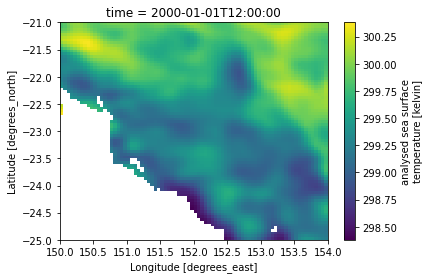

In [6]:
sst_ds["analysed_sst"].sel(time="2000-01-01").sel(lat=slice(lat_min,lat_max),lon=slice(lon_min,lon_max)).plot()

### 1.2 Create a climatology

We will choose a 20-year period for our climatology and compute the 90th percentile SSTs for ech day of the year using an 11 day sliding window, over the given region only.

In [7]:
climatology_start = "1990-01-01"
climatology_end = "2009-12-31"

In [8]:
climatology_raw_data = sst_ds["analysed_sst"] \
     .sel(time=slice(climatology_start,climatology_end)) \
     .sel(lat=slice(lat_min,lat_max),lon=slice(lon_min,lon_max))

In [43]:
climatology_rolling = climatology_raw_data.chunk({"lat": 10, "lon": 10, "time":-1}) \
    .rolling(time=11,center=True) \
    .construct("window")

In [44]:
climatology_90th_percentile = climatology_rolling.chunk({"time":-1}) \
    .groupby("time.dayofyear") \
    .quantile(0.9,dim=["time","window"]).load()

/Users/cv922550/venvs/sst_data/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


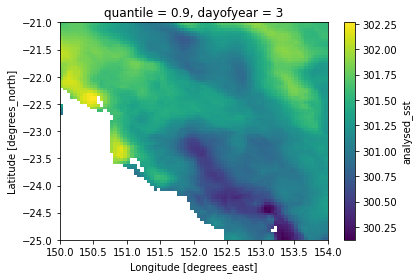

In [45]:
climatology_90th_percentile.sel(dayofyear=3).plot()

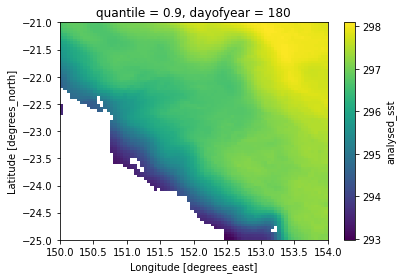

In [46]:
climatology_90th_percentile.sel(dayofyear=180).plot()

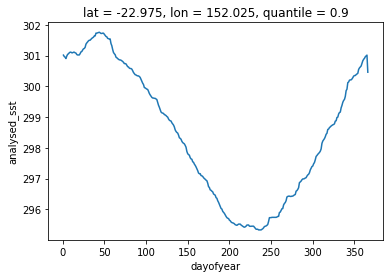

In [47]:
climatology_90th_percentile.sel(lat=(lat_min+lat_max)/2,lon=(lon_min+lon_max)/2,method="nearest").plot()

### 1.3 Apply the climatology to SST data over a given period to look for marine heatwaves


In [60]:
# define the period of interest

period = ("2018-01-01","2018-12-31")

In [61]:
# get the SST data for the area and time period in question

import datetime
# classify as a heatwave if the temperature is above the 90th percentile for 5 consecutive days
time_window_days = 5
# investigate the following period

start_date = datetime.datetime.strptime(period[0],"%Y-%m-%d")
end_date = datetime.datetime.strptime(period[1],"%Y-%m-%d")
# need to widen the time range by +/- time_window_days to get accurate heatwave information for this period
data_start_date = start_date - datetime.timedelta(days=time_window_days)
data_end_date = end_date +  datetime.timedelta(days=time_window_days)

sst_data = sst_ds["analysed_sst"].sel(time=slice(start_date,end_date)) \
     .sel(lat=slice(lat_min,lat_max),lon=slice(lon_min,lon_max)) \
     .load()

In [49]:
# create a new dataarray with dayofyear instead of time 
sst_data["dayofyear"] = sst_data.time.dt.dayofyear
sst_data_doy = xr.DataArray(data=sst_data.data, dims=["dayofyear","lat", "lon"], coords=[sst_data.dayofyear,
                                                                                     sst_data.lat,
                                                                                     sst_data.lon])

In [50]:
n_lats = len(sst_data_doy["lat"])
n_lons = len(sst_data_doy["lon"])
n_days = len(sst_data_doy["dayofyear"])

In [51]:
# create an array to hold a count of the numbers of consecutive hot days
# we will step through the time period and update this array
hot_day_count = np.zeros(shape=(n_lats,n_lons))

In [52]:
mhw_flags = np.zeros(shape=(n_days,n_lats,n_lons))
for day in range(n_days):
    doy = sst_data2["dayofyear"].values[day]
    # update the hot_day_count for this day
    hot_day_count = xr.where(sst_data2.sel(dayofyear=doy) > climatology_90th_percentile.sel(dayofyear=doy),hot_day_count+1,0).values
    # wherever there are more than time_window_days of hot weather, flag the current day and the 
    # preceeding (time_window_days-1) days as heat wave days
    mhw = hot_day_count >= time_window_days
    for prev in range(max(0,day-time_window_days+1),day+1):
        mhw_flags[prev,:,:] = np.where(mhw,1,mhw_flags[prev,:,:])
    
mhw_flags = np.where(np.isnan(sst_data),np.nan,mhw_flags)

mhw = xr.DataArray(data=mhw_flags,dims=["time","lat", "lon"], 
                   coords=[sst_data.time, sst_data2.lat, sst_data2.lon])
mhw = mhw.sel(time=slice(period[0],period[1]))

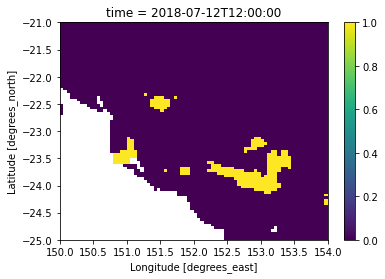

In [53]:
# check which areas are experiencing a marine heatwave on a particular date
mhw.sel(time="2018-07-12").plot()

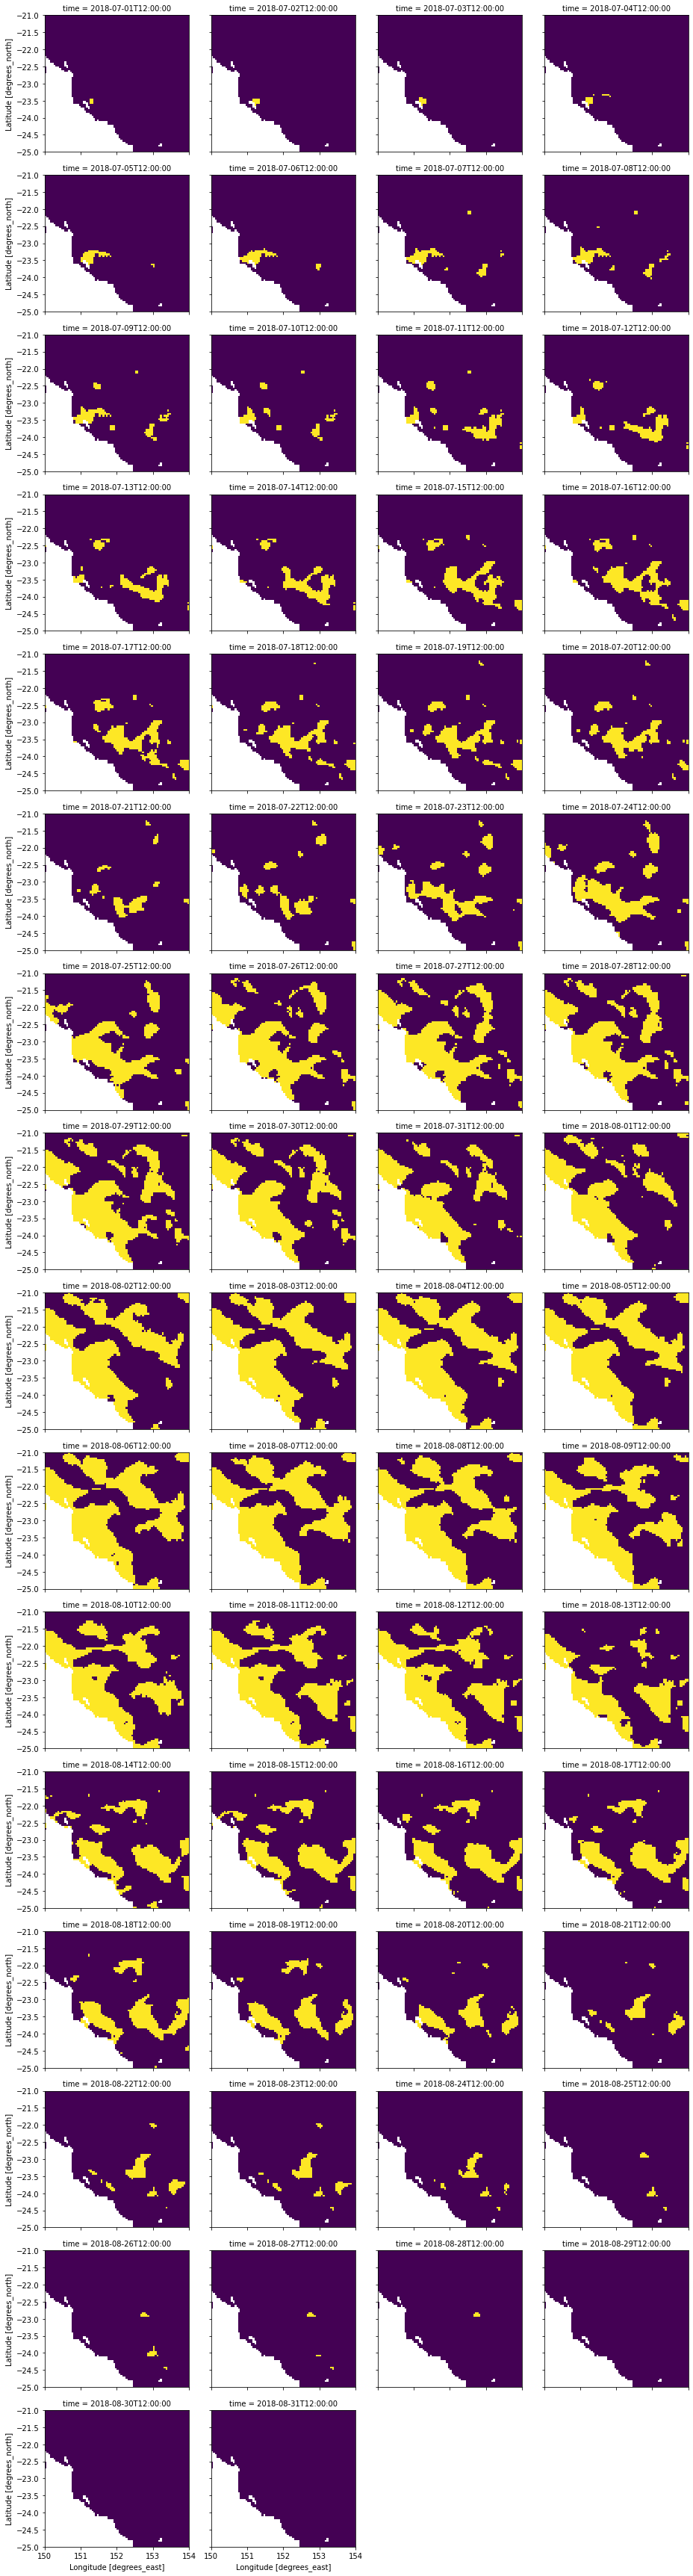

In [74]:
# visualise the devlopment of a marine heatwave over a two month period in southern hemisphere the winter of 2018

mhw.sel(time=slice("2018-07-01","2018-08-31")).plot(col="time",col_wrap=4,add_colorbar=False)
   